# Predicting Log Error from Zillow's Zestimate


In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import math

import acquire

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

## Acquiring the Data
A dataframe is acquired from Codeup's SQL zillow database using the `prepare_zillow()` function from acquire.py. 

`prepare_zillow()` returns a dataframe split into train, validate, and test based on the requirements detailed in the README.

In summary:
1. Data was obtained from Codeup's SQL database
2. fips codes were converted into county names
3. Outliers were compressed
4. Missing values were dropped or imputed

In [2]:
train, validate, test = acquire.prepare_zillow()

In [3]:
train.shape, validate.shape, test.shape

((52518, 25), (13130, 25), (7295, 25))

In [4]:
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,1916.0,38403.0,294146.0,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,1970.0,360413.0,604073.0,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,1980.0,106726.0,177748.0,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,1974.0,160407.0,267340.0,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,1922.0,159987.0,338075.0,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52518 entries, 48285 to 12816
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52518 non-null  float64
 1   bedroomcnt                    52518 non-null  float64
 2   buildingqualitytypeid         52518 non-null  float64
 3   calculatedfinishedsquarefeet  52518 non-null  float64
 4   fips                          52518 non-null  object 
 5   fullbathcnt                   52518 non-null  float64
 6   heatingorsystemtypeid         52518 non-null  float64
 7   latitude                      52518 non-null  float64
 8   longitude                     52518 non-null  float64
 9   lotsizesquarefeet             52518 non-null  float64
 10  propertycountylandusecode     52518 non-null  object 
 11  propertylandusetypeid         52518 non-null  object 
 12  rawcensustractandblock        52518 non-null  object 
 1

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,52518.0,2.288606e+00,0.945545,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
bedroomcnt,52518.0,3.023021e+00,1.001980,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+01
buildingqualitytypeid,52518.0,6.639845e+00,1.351593,1.000000e+00,6.000000e+00,6.639845e+00,7.000000e+00,1.200000e+01
calculatedfinishedsquarefeet,52518.0,1.758181e+03,903.319191,1.520000e+02,1.174000e+03,1.524000e+03,2.074000e+03,7.495000e+03
fullbathcnt,52518.0,2.219334e+00,0.928838,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
heatingorsystemtypeid,52518.0,3.237995e+00,3.052119,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01
latitude,52518.0,3.400924e+07,269800.378244,3.333953e+07,3.381096e+07,3.402277e+07,3.417770e+07,3.481240e+07
longitude,52518.0,-1.181983e+08,361368.221699,-1.194484e+08,-1.184198e+08,-1.181687e+08,-1.179174e+08,-1.175575e+08
lotsizesquarefeet,52518.0,1.294979e+04,14041.788327,2.360000e+02,5.999000e+03,7.290500e+03,1.088775e+04,5.129950e+04
yearbuilt,52518.0,1.969847e+03,23.036533,1.878000e+03,1.954000e+03,1.971000e+03,1.987000e+03,2.016000e+03


## Exploration
The goal of this project is to identify drivers of log error. Ideally, we develop a model that is able to predict log error. We will investigate this data through a series of questions.

### Q1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

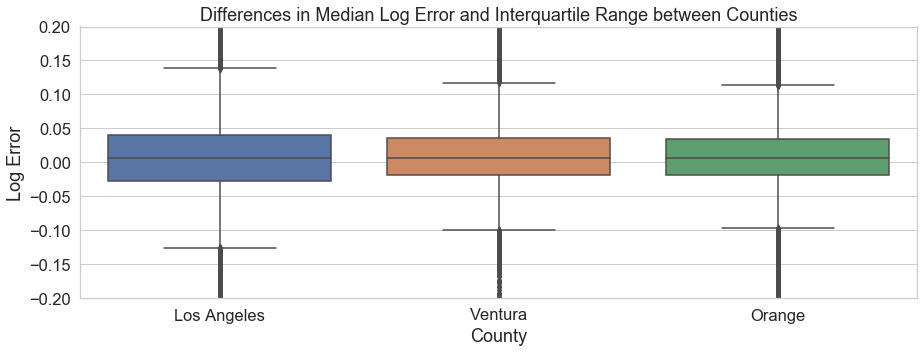

In [7]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .2) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.fips, y=train.logerror)
plt.title('Differences in Median Log Error and Interquartile Range between Counties')
plt.xlabel('County')
plt.ylabel('Log Error')
plt.show()

In [8]:
train.groupby('fips').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
fips,,,,,,,,
Los Angeles,33916.0,0.013910,0.151394,-4.655420,-0.026780,0.006472,0.039737,3.394544
Orange,14447.0,0.020867,0.187606,-2.406257,-0.018078,0.006907,0.034739,2.933328
Ventura,4155.0,0.016276,0.159583,-2.922919,-0.018415,0.006452,0.036050,2.311174


We can use a one-way Anova to determine if there is a meaningful difference in these means. The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

1. The samples are independent. (Appears to be True)
2. Each sample is from a normally distributed population. (Appears to be True)
3. The standard deviations of the groups are all equal. (Appears to be True)

There might be some minor violation of these assumptions, but if our p-value is low enough, we can be confident in our evaluation. 

$H_0$: There is no difference between the mean log error of these counties.

$H_a$: At least one of these counties has a mean log error that is different from at least one other counties mean log error.

In [9]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 'Los Angeles'], train.logerror[train.fips == 'Orange'], train.logerror[train.fips == 'Ventura'])
F, p

(9.257558206936508, 9.554371845955292e-05)

In [10]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


Performance of the Kruskal-Wallis test further solidifies our case

$H_0$: There is no difference between the median log error of these counties

$H_a$: At least one of these counties has a median log error that is different from at least one other counties median log error.

In [11]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.fips == 'Los Angeles'], train.logerror[train.fips == 'Orange'], train.logerror[train.fips == 'Ventura'])
H, p

(15.284584916994751, 0.0004797274352874927)

In [12]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeaways:
There is some difference in Zestimate's ability to predict based on the fips county location data. This location data is a good candidate for a model feature.

### Q2. Is there a relationship between tax assessed property values and log error?

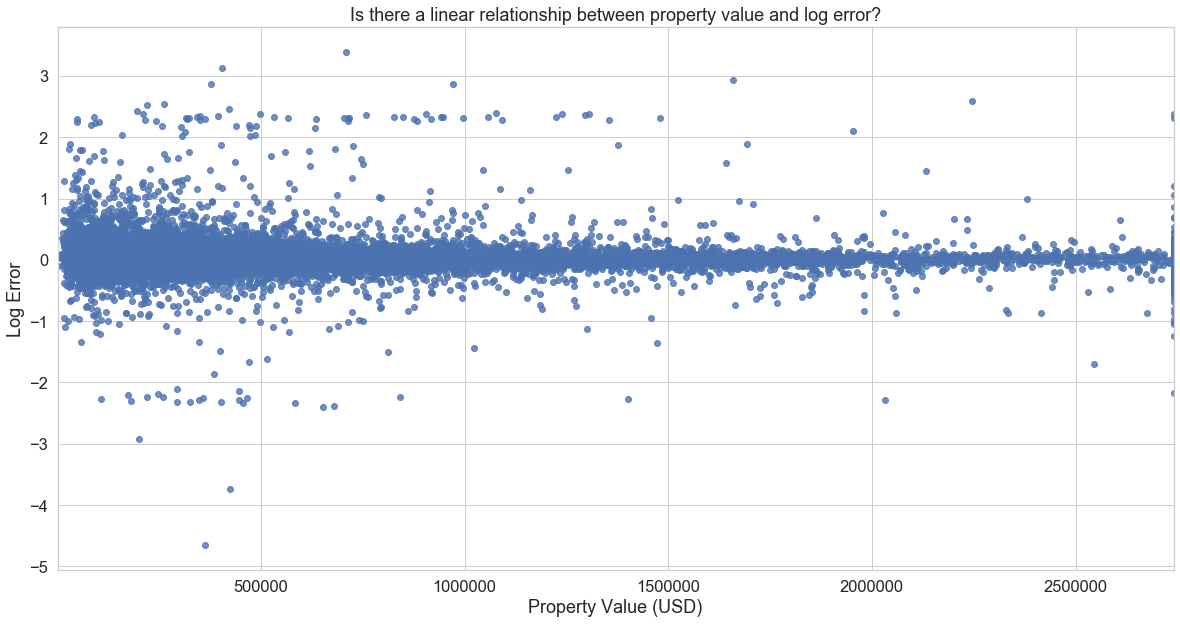

In [13]:
plt.figure(figsize=(20,10))
sns.regplot(data=train, x=train.taxvaluedollarcnt, y= train.logerror)
plt.title('Is there a linear relationship between property value and log error?')
plt.xlabel('Property Value (USD)')
plt.ylabel('Log Error')
plt.show()

Visual inspection of a scatterplot with line of best fit demonstrates that there is no linear relationship between log error and property value, but it appears that the variance of the logerror increases as property value decreases. We can look at this in more detail.

Let's begin by creating a variable absolute_logerror that is the absolute value of the logerror for each observation. Then we can see if there is a linear relationship between absolute logerror and property value.

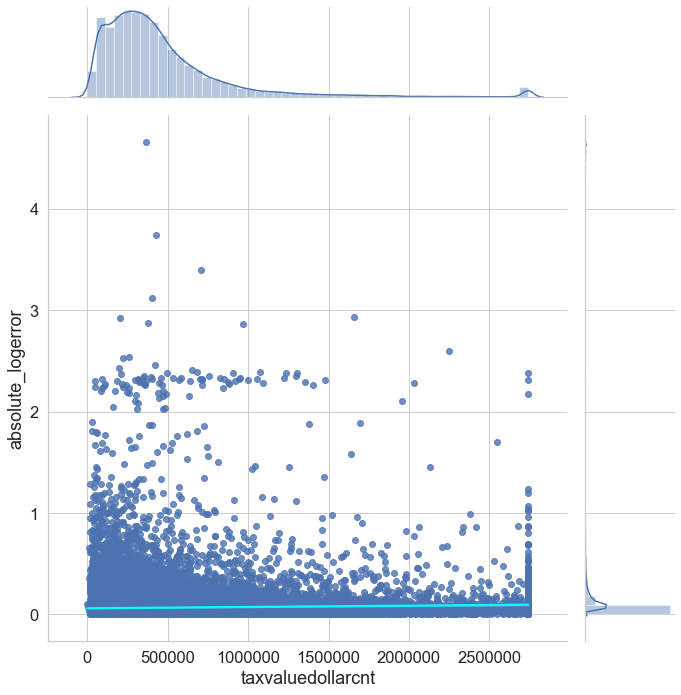

In [14]:
train['absolute_logerror'] = abs(train.logerror)
g = sns.jointplot(height = 10, x="taxvaluedollarcnt", y="absolute_logerror", data=train, kind='reg',
                  joint_kws={'line_kws':{'color':'cyan'}}) # Only regression cyan

This doesn't look too promising. The line of best fit is accommodating the compressed upper outliers and appears to be relatively flat overall. Perhaps a better approach will be to bin the data and see if there are meaningful differences between parts of the distribution. 

Text(0, 0.5, 'Log Error')

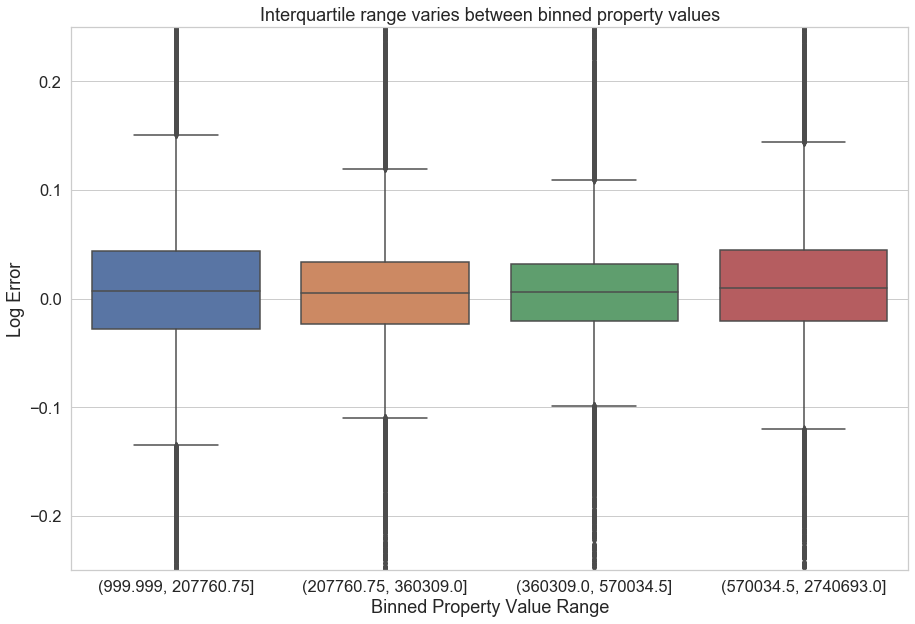

In [15]:
train['binned_value'] = pd.qcut(train['taxvaluedollarcnt'], q=4)
plt.figure(figsize=(15, 10))
plt.ylim(-.25, .25)
sns.boxplot(data=train, x='binned_value', y='logerror')
plt.title('Interquartile range varies between binned property values')
plt.xlabel('Binned Property Value Range')
plt.ylabel('Log Error')

Visual inspection appears to show that there are differences in the interquartile ranges between the binned property value groups.

In [16]:
train.groupby('binned_value').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
binned_value,,,,,,,,
"(999.999, 207760.75]",13130.0,0.021265,0.167731,-2.922919,-0.027911,0.006704,0.043596,2.426789
"(207760.75, 360309.0]",13130.0,0.014490,0.149805,-2.312395,-0.023628,0.004606,0.033694,2.536896
"(360309.0, 570034.5]",13128.0,0.010866,0.146687,-4.655420,-0.020675,0.005679,0.031326,3.123634
"(570034.5, 2740693.0]",13130.0,0.017423,0.184069,-2.406257,-0.021026,0.009958,0.045024,3.394544


There appear to be differences in the means between these groups. We can confirm this with a one-way anova.

$H_0$: There is no difference in the mean log error of these property value quartiles

$H_a$: There is at least one mean log error that differs from on other mean log error within these property value quartiles.

In [17]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.binned_value.isin((999.999, 207760.75))], 
                      train.logerror[train.binned_value.isin((207760.75, 360309.0))], 
                      train.logerror[train.binned_value.isin((360309.0, 570034.5))],
                      train.logerror[train.binned_value.isin((570034.5, 2740693.0))])
F, p

(10.91553392859798, 3.652443823239081e-07)

In [18]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeaways:
- There appears to be a lot of value in binning these property values. The value of categorizing records into bins may be improved through the use of k-means clustering. 

### Q3. Which variables have the highest correlation with logerror?

In [19]:
import explore

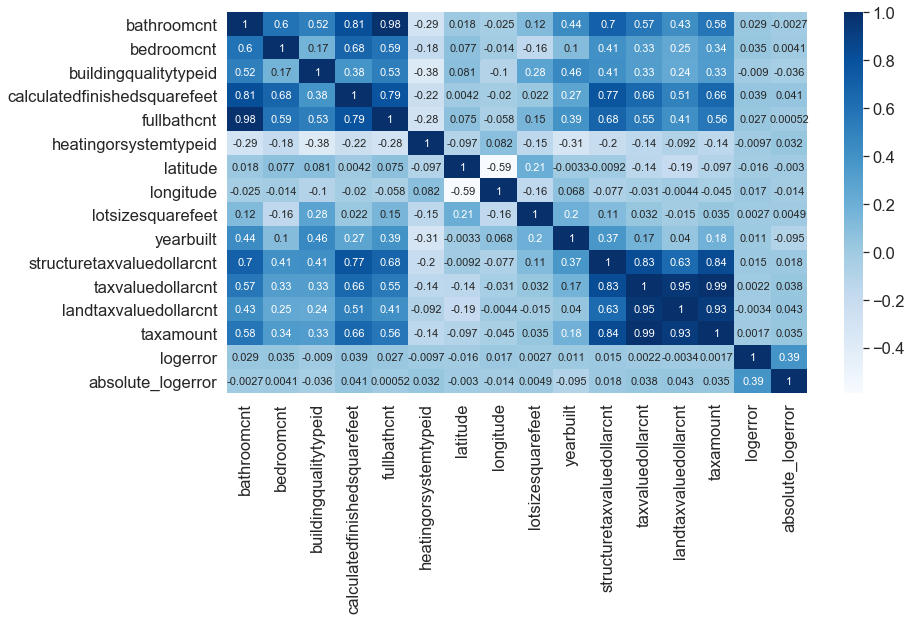

In [20]:
explore.corr_plot(train)

There do not appear to be many strong linear correlations between any of the numeric variables and logerror. As we saw earlier however, the lack of a linear correlation does not mean that there is no relationship. We may be able to magnify some of these interactions through clustering techniques. We can review a pairplot to see the interactions between these variables.

There is quite a bit of collinearity between these variables because they represent the same characteristics (ex: `fullbathcount` and `bathroomcnt`). At this point, its more useful to look at the interactions of features that do not have such a high degree of collinearity. These will be the features we pass into our pairplot. 

KeyboardInterrupt: 

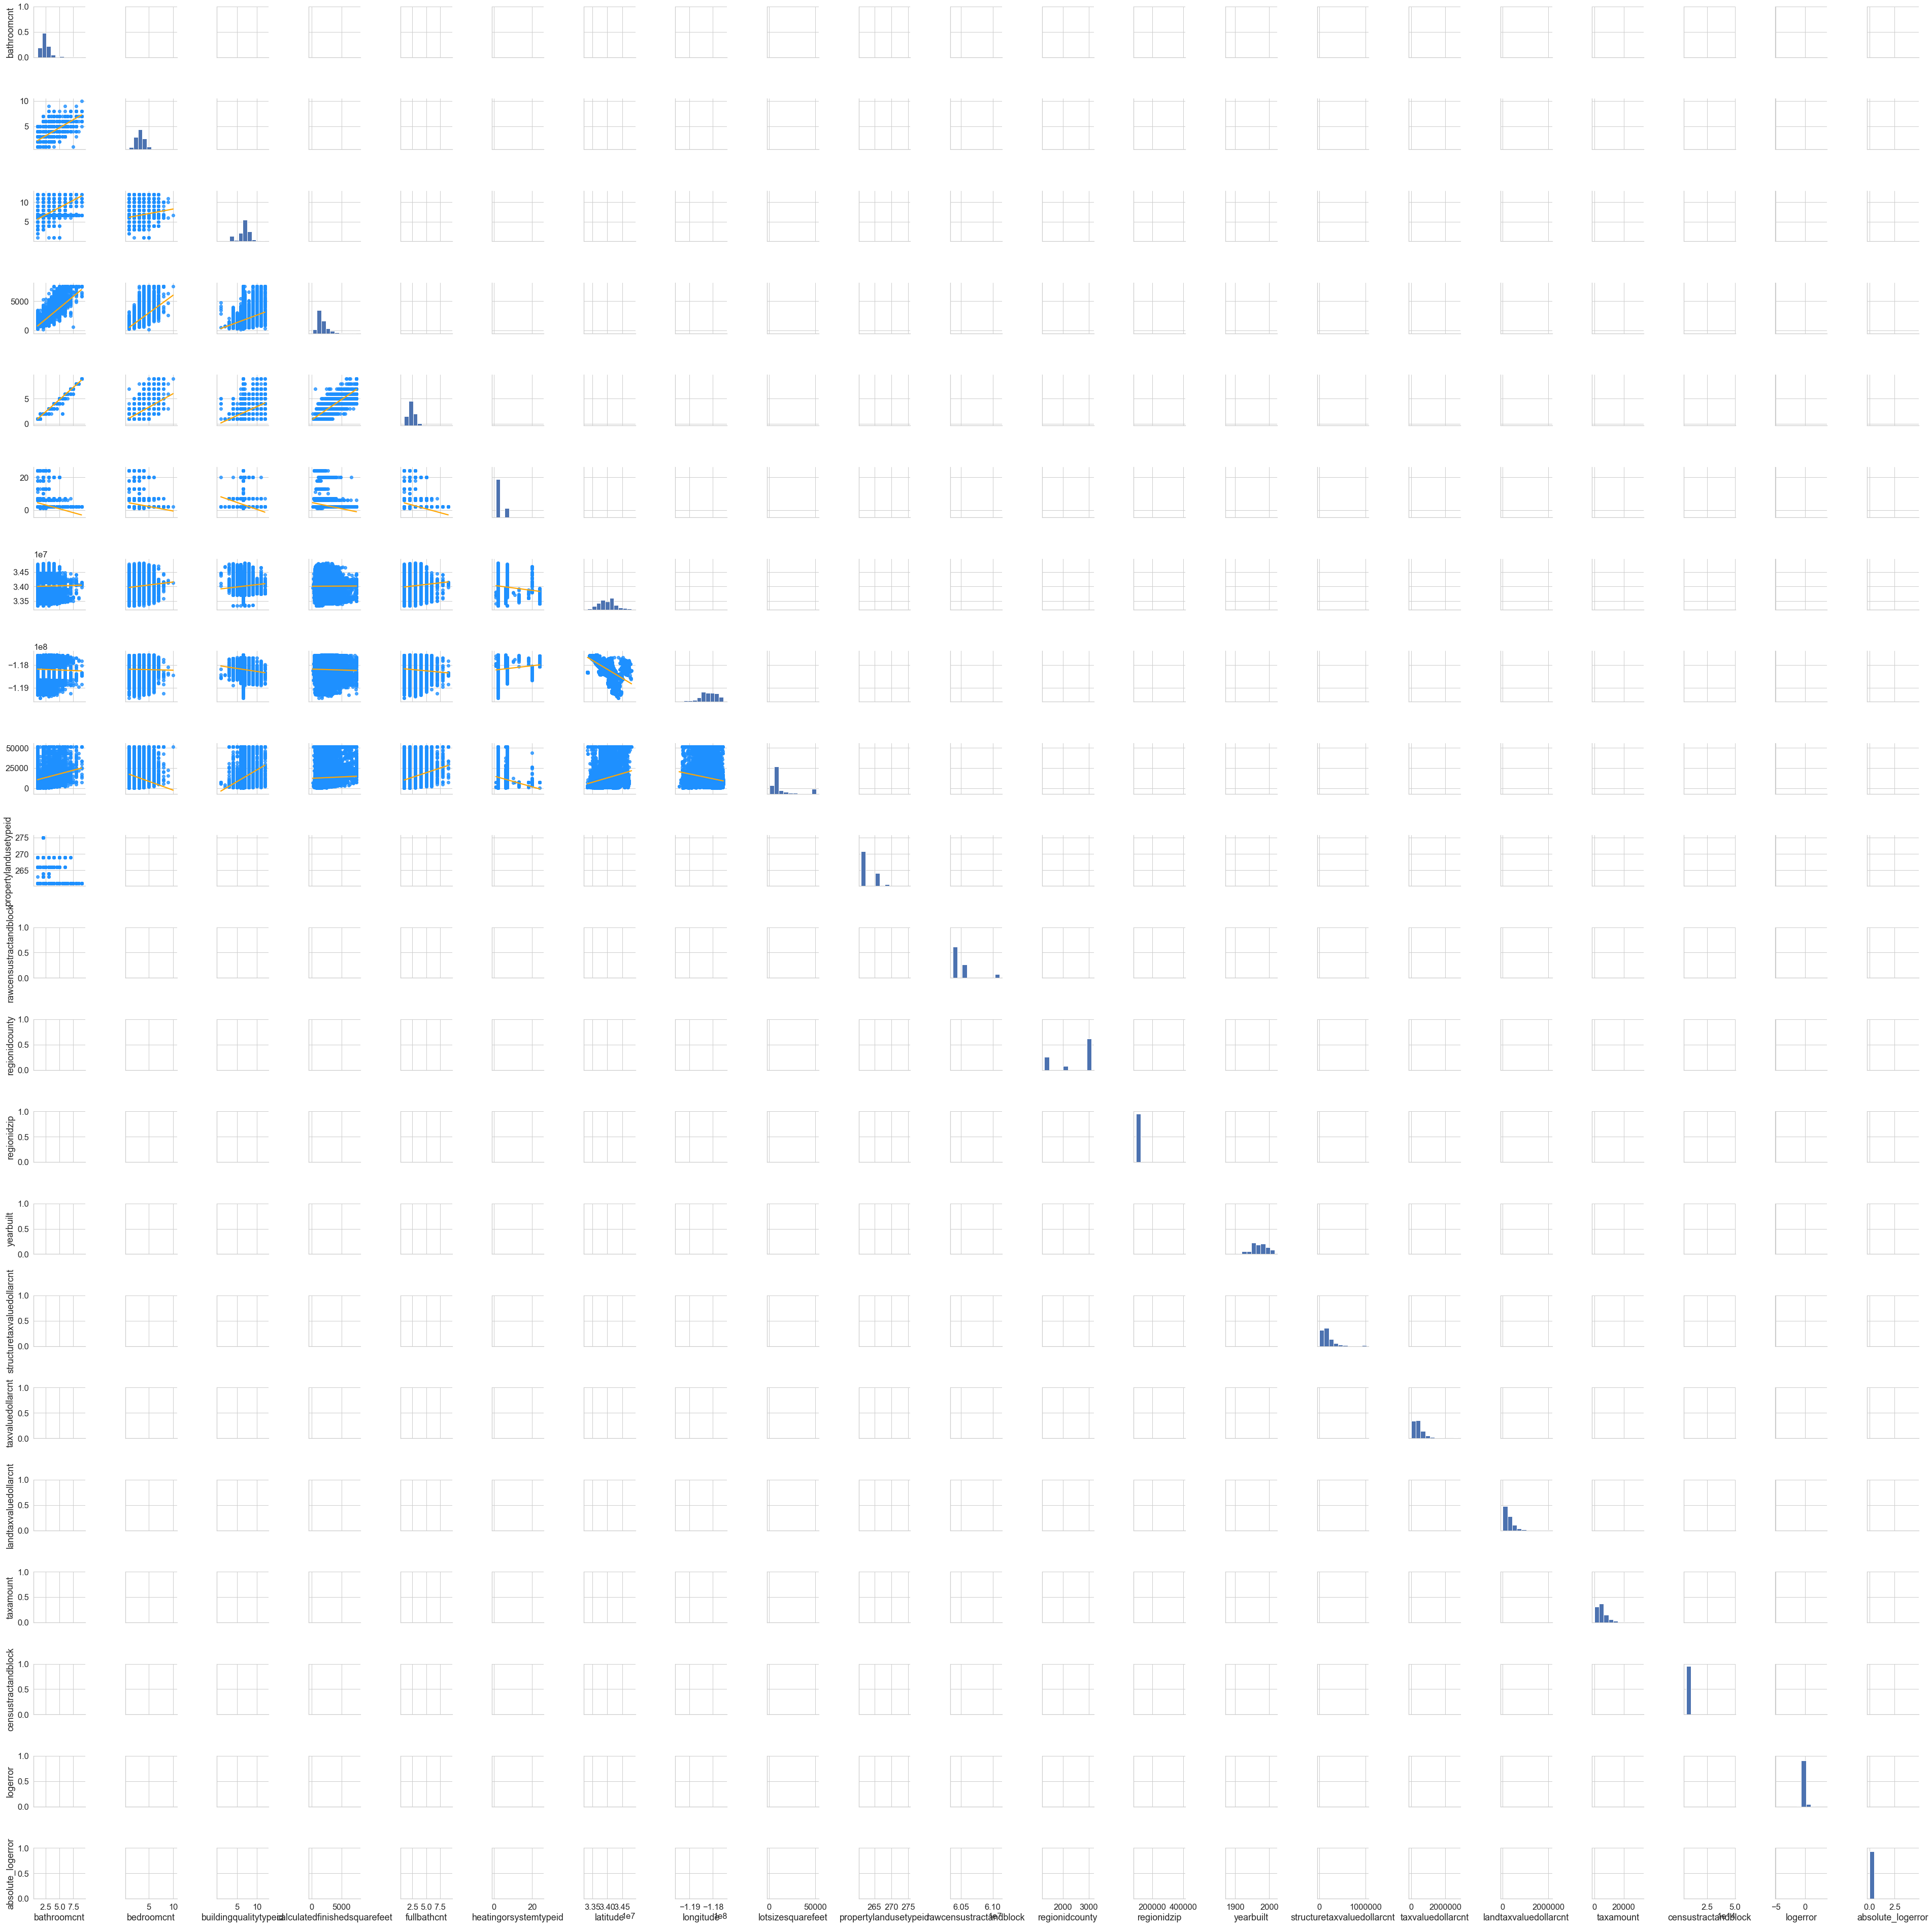

In [21]:
pairs = train['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', ]
explore.plot_pairs(train)

To begin clustering, we will need to scale the data.

In [ ]:
train.drop(columns=['absolute_logerror', 'binned_value'], inplace=True)
scaler, train_scaled, validate_scaled, test_scaled = explore.standard_scaler(train, validate, test)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52518 entries, 48285 to 12816
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   52518 non-null  float64 
 1   bedroomcnt                    52518 non-null  float64 
 2   buildingqualitytypeid         52518 non-null  float64 
 3   calculatedfinishedsquarefeet  52518 non-null  float64 
 4   fips                          52518 non-null  object  
 5   fullbathcnt                   52518 non-null  float64 
 6   heatingorsystemtypeid         52518 non-null  float64 
 7   latitude                      52518 non-null  float64 
 8   longitude                     52518 non-null  float64 
 9   lotsizesquarefeet             52518 non-null  float64 
 10  propertycountylandusecode     52518 non-null  object  
 11  propertylandusetypeid         52518 non-null  object  
 12  rawcensustractandblock        52518 non-nu